# Import Libraries

In [151]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

plt.style.use('dark_background')

import pytesseract

In [152]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Import Image

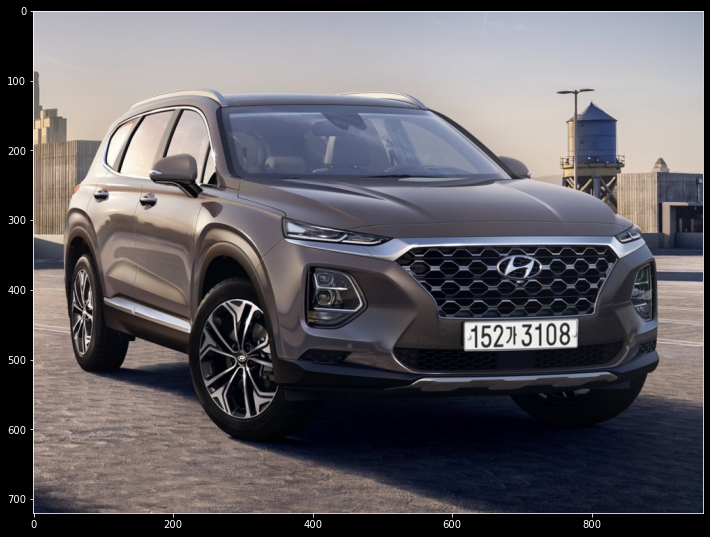

In [164]:
# 이미지 불러오기
img = cv2.imread('license_plate/lpr6.jpg')
img_ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 사이즈 지정
height, width, channel = img_ori.shape

# 이미지 출력
plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.show()

# Convert Image to Grayscale

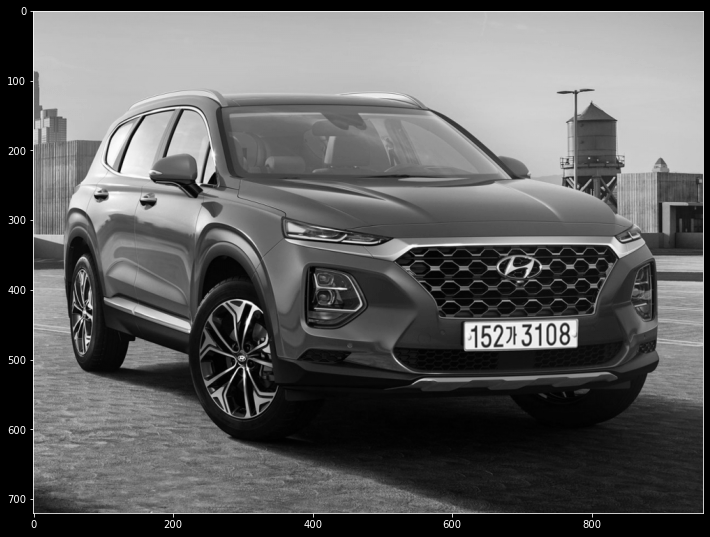

In [165]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.show()

# Maximize Contrast (Morphology Tranformation)
- Optional
- https://red-pulse.tistory.com/190

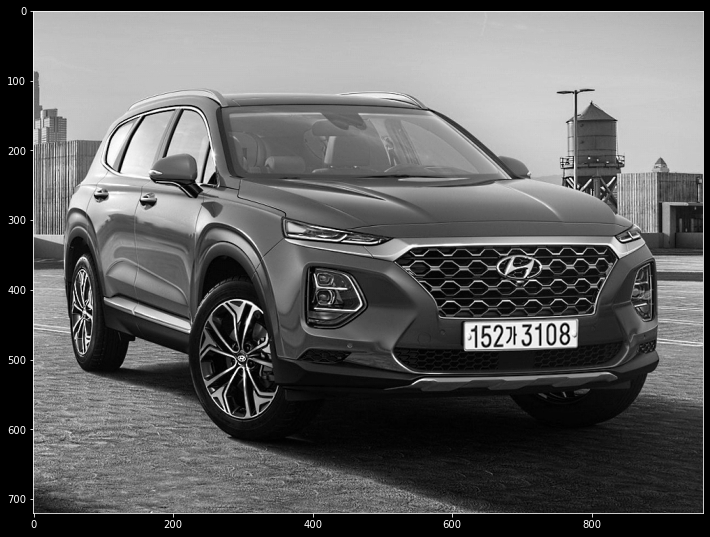

In [166]:
# 이미지 Segmentation 단순화, 제거, 보정 역할
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3)) # 직사각형 커널

# tophat - 원본 이미지와 opening 이미지 차이
# blackhat - 원본 이미지와 closing 결과의 차이
imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat) 
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.show()

# Gaussian Blur & Adaptive Thresholding

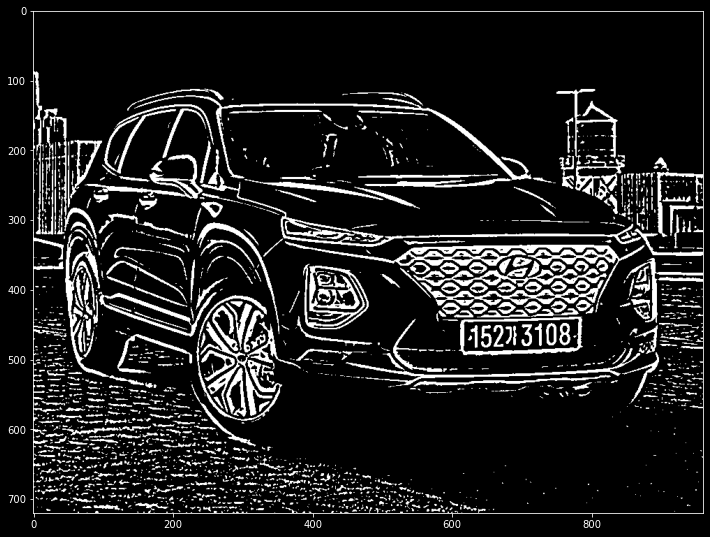

In [167]:
# 노이즈 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

# 임계값을 지정하여 흑과 백으로 분할
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.show()

# Find Contours

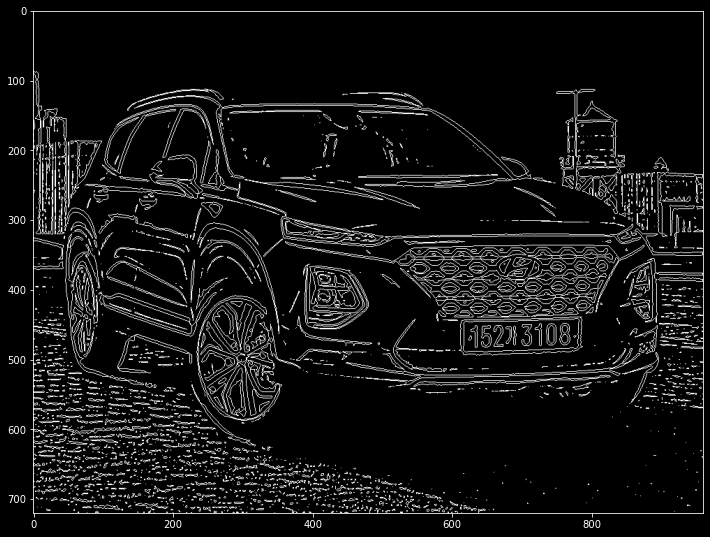

In [168]:
# 윤곽선 구하기
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 전체 윤곽선 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.show()

# Prepare Data

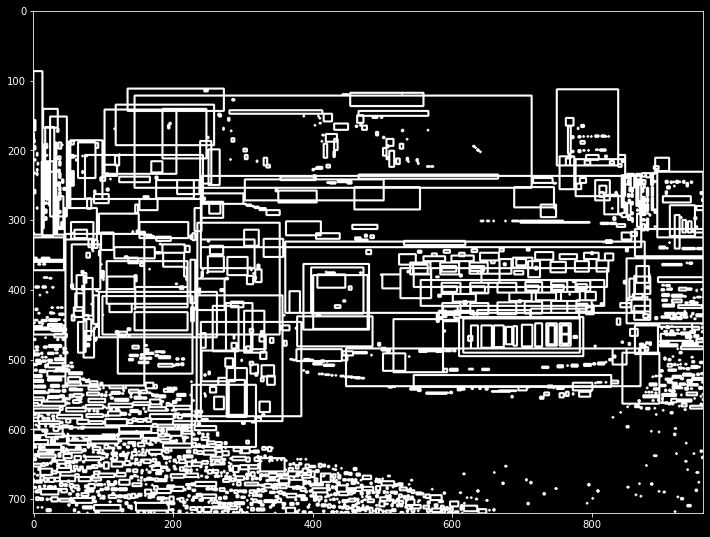

In [169]:
temp_result = np.zeros((height,width,channel),dtype=np.uint8)

contours_dict =[]

for contour in contours:
    # 윤곽선을 감싸는 사각형의 x,y 좌표와 너비, 높이 저장
    x, y, w, h = cv2.boundingRect(contour)
    # 사각형 그리기
    cv2.rectangle(temp_result,pt1=(x, y),pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    contours_dict.append({
        'contour':contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2), # 사각형 중심 좌표
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.show()

# Select Candidates by Char Size

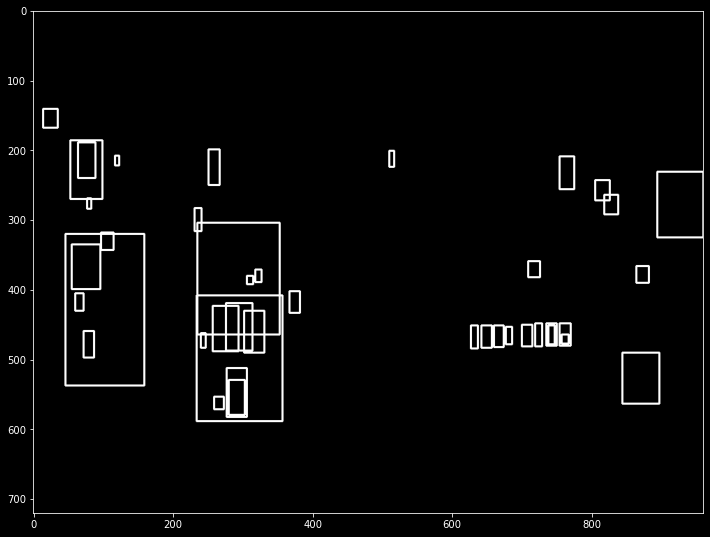

In [170]:
# 하이퍼 파라미터: bounding box 의 최소 넓이
MIN_AREA = 80 

# 하이퍼 파라미터: bounding box 의 최소 넓이, 높이
MIN_WIDTH, MIN_HEIGHT = 3, 8

# 하이퍼 파라미터: bounding box 의 세로 대비 가로의 비율
MIN_RATIO, MAX_RATIO = 0.3, 0.8

# 유망한 윤곽선 후보군
possible_contours = []
 
cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
temp_result = np.zeros((height,width,channel),dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'],d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
     
plt.figure(figsize=(12,10))
plt.imshow(temp_result)
plt.show()

# Select Candidates by Arrangement of Contours
- 윤곽선 후보군들의 배열(정렬 방식)을 확인

In [171]:
# 하이퍼 파라미터: contour간의 길이가 contour의 대각선 길이의 최대 5배 이하
MAX_DIAG_MULTIPLYER = 6
# 하이퍼 파라미터: contour간의 각도(세타) 차이가 최대 12도 이하
MAX_ANGLE_DIFF = 15.0
# 하이퍼 파라미터: 면적 넓이 차이
MAX_AREA_DIFF = 1.5
# 하이퍼 파라미터: contour간 길이 차이
MAX_WIDTH_DIFF = 1
# 하이퍼 파라미터: contour간 높이 차이
MAX_HEIGHT_DIFF = 0.2
# 하이퍼 파라미터: 위 조건 5가지를 만족한 윤곽선 배열의 box가 최소 5개 이상
MIN_N_MATCHED = 5

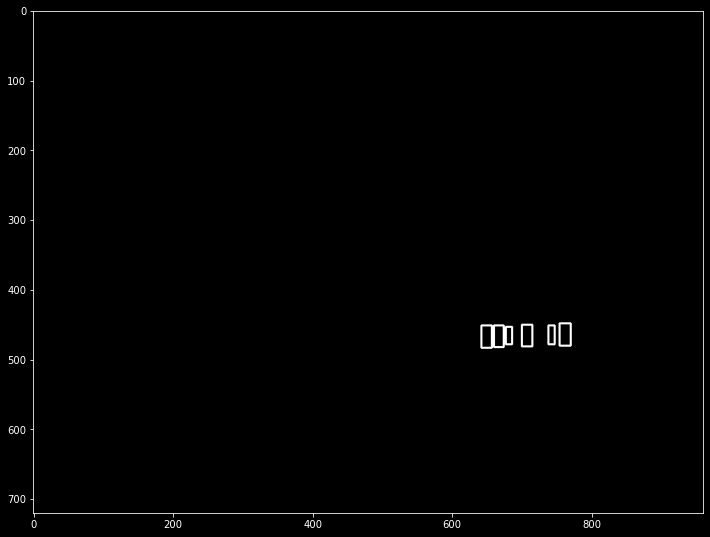

In [172]:
# 재귀함수로 사용하기 위해 함수 생성
def find_chars(contour_list):
    # 최종 결과물 인덱스
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            # 같은 윤곽선 비교 제외
            if d1['idx'] == d2['idx']:
                continue
            
            dx = abs(d1['cx']-d2['cx'])
            dy = abs(d1['cy']-d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2)
            
            # contour간 거리 구하기
            distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            # 각도 차이 구하기
            if dx == 0: # 예외 처리
                angle_diff = 90
            else:
                # arctan 값 = 세타값 (tan세타 = dy/dx) degrees로 라디안을 degree로 바꿈
                angle_diff = np.degrees(np.arctan(dy/dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) # 면적 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이 비율
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
            
        # append first contour
        matched_contours_idx.append(d1['idx'])
        
        # 번호판 후보군 배열의 길이가 3보다 작으면 번호판일 확률 X -> 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        # 최종 후보군(결과물)
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx=[]
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        # numpy take로 possible_contours에서 unmatched_contour_idx와 같은 인덱스 값 추출 
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # 다시 재귀적으로 한 번 더 점검
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
    
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
    
# 윤곽선 후보군 시각화
temp_result = np.zeros((height,width,channel),dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255),thickness=2)
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.show()

# Rotate Plate Images (Affine Tranform)

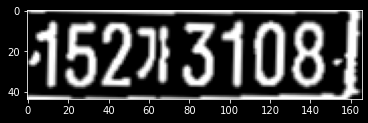

In [173]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars= sorted(matched_chars, key=lambda x: x['cx']) # x 방향 순차 정렬
    
    plate_cx=(sorted_chars[0]['cx']+sorted_chars[-1]['cx'])/2
    plate_cy=(sorted_chars[0]['cy']+sorted_chars[-1]['cy'])/2
    
    plate_width = (sorted_chars[-1]['x']+sorted_chars[-1]['w']-sorted_chars[0]['x'])* PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
        
    plate_height=int(sum_height/ len(sorted_chars)* PLATE_HEIGHT_PADDING)
    
    # 회전 각도 구하기 (arcsin)
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    # degree로 변환
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # 로테이션 매트릭스 구하기
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx,plate_cy), angle=angle, scale=1.0)
    
    # 이미지를 변형
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
        
    # 번호판 부분만 자르기
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.show()

# Another Thresholding to Find Chars
- Find contours again (재점검)
- OTSU thresholding
- Pytesseract OCR

번호판: 152가3108


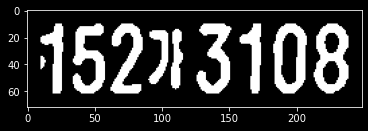

In [174]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 한번 더 윤곽선 찾기
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        # 조건에 맞게 최대 최소 구하기
        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    # 번호판 영역만 Crop
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # 노이즈 없애고 쓰레시 홀딩, Padding주기
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0) # 노이즈 제거
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU) # threshold 한 번 더
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0)) # 패딩으로 여백 생성

    # 테서렉트 OCR
    chars = pytesseract.image_to_string(img_result, lang='kor') # oem 0번 엔진 (문맥 파악 X)
    # chars = pytesseract.image_to_string(img_result, lang='kor')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit(): # 한글이 포함되어 있는지
            if c.isdigit(): # 숫자가 하나라도 있는지
                has_digit = True
            result_chars += c
    
    if len(result_chars) == 0 or len(result_chars) > 11:
        print("번호판이 아닙니다.")
    else:
        print("번호판:", result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text: # 가장 문자열이 긴 것을 선택
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.show()

# Result

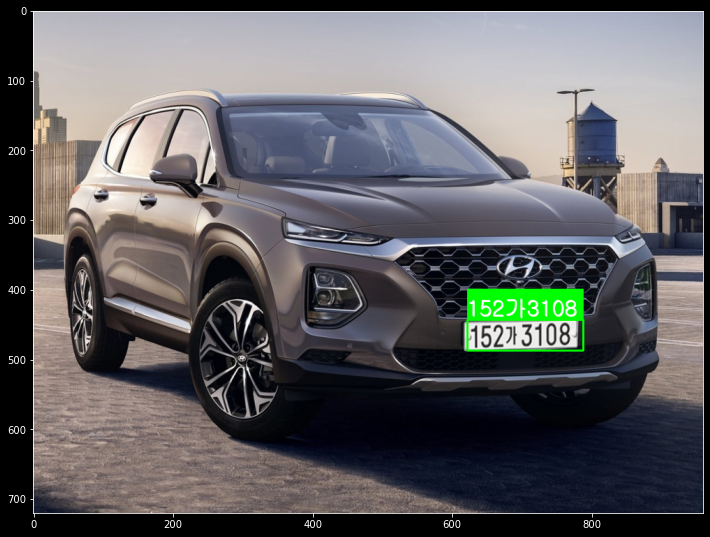

In [213]:
# info = plate_infos[longest_idx]
# chars = plate_chars[longest_idx]

img_out = img_ori.copy() # 원본 이미지 불러오기

for i in range(len(plate_infos)):
    info = plate_infos[i]
    chars = plate_chars[i]
    pt1 = [info['x'], info['y']]
    pt2 = [info['x']+info['w'], info['y']+info['h']]
    
    img_out = Image.fromarray(img_out) # PIL이 처리 가능하도록 변환
    draw = ImageDraw.Draw(img_out)
    fontsize = 32
    
    font = ImageFont.truetype("fonts/gulim.ttc", fontsize)
    
    # print(chars, "차량이 검출되었습니다.")
    if len(chars) != 0 and len(chars) < 10: 
        draw.rectangle((pt1[0], pt1[1] - info['h'], pt2[0], pt2[1] - info['h']), fill=(0,255,0))
        draw.text((pt1[0], pt1[1] - fontsize), chars, font=font, fill=(255,255,255)) # text를 출력
        draw.text((pt1[0] + 0.5, pt1[1] - fontsize + 0.5), chars, font=font, fill=(255,255,255)) # text를 출력
        draw.text((pt1[0] - 0.5, pt1[1] - fontsize - 0.5), chars, font=font, fill=(255,255,255)) # text를 출력
        
    img_out = np.array(img_out) # 다시 OpenCV가 처리 가능하도록 np 배열로 변환
    img = cv2.rectangle(img_out, pt1=pt1, pt2=pt2, color=(0,255,0), thickness=2)
    # img = cv2.putText(img_out, chars, (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    
    
cv2.imwrite(chars + '.jpg', img_out) # 번호판 검출 이미지 저장

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.show()

# Electronic Car Detection

450 6854
전기 자동차가 아닙니다.


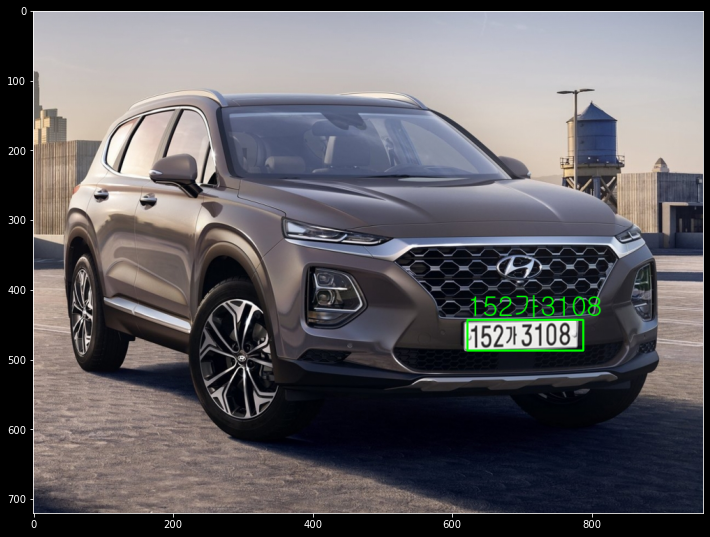

-1

In [179]:
# 번호판 구역 추출
plate = img_out[info['y']:info['y']+info['h'], info['x']:info['x']+info['w']]
height, width, channel = plate.shape

isElectronic = 0 
notElectronic = 0

elec_range = cv2.inRange(plate, (50, 150, 170), (200, 230, 255)) # 전기자동차 번호판 색상 인식 픽셀 범위 설정(하이퍼 파라미터)

for y in range(height):
    for x in range(width):
        if elec_range[y, x] >= 1: # 픽셀 값이 1 이상이면 전기차로 가정
            isElectronic += 1
        else:
            notElectronic += 1
                                  
print(isElectronic, notElectronic)
            
if 10 * isElectronic >= notElectronic: # 10배(하이퍼 파라미터) 이상 차이가 나면 전기자동차로 인식
    print("전기 자동차가 검출되었습니다.")

else:
    print("전기 자동차가 아닙니다.")
    
plt.figure(figsize=(12, 10))
plt.imshow(img_out)
plt.show()
elec_image = cv2.imshow('electronic_license_plate', elec_range)
cv2.waitKey()